In [ ]:
require(ggplot2)
require(mgcv)
require(lme4)
require(dplyr)

In [2]:
data = read.csv("data/aligned_ac_data.csv")[,-1]
names(data) = gsub("comp\\.([12])", "comp\\1", names(data))
data$filename = factor(data$filename)
data$collapse_func = factor(data$collapse_func)

In [3]:
head(data)

,ac_id,has_match,time_start,time_end,time_midpoint,speaker_gender,context_raw,position,syllable_structure,nasalized_perceived,⋯,offset_id,offset_s,phone,filename,comp1,comp2,next_offset_s,emit_id,has_midpoint,collapse_func
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<int>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<fct>
1,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,439,13.17,n,劉櫂豪-127903,27.941244,29.770956,13.38,18,False,b
2,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,446,13.38,y,劉櫂豪-127903,-30.644875,-5.742225,13.50,19,False,b
3,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,450,13.50,ɕ,劉櫂豪-127903,57.967636,-22.112434,13.56,20,False,b
4,104,yes,13.10793,13.84637,13.72715,m,h_oN_f,f,cv,1,⋯,452,13.56,a,劉櫂豪-127903,-6.503804,41.149845,13.92,21,True,b
5,105,yes,21.15613,21.80866,21.73240,m,h_oN_f,f,cv,1,⋯,707,21.21,p,劉櫂豪-127903,-4.906386,-52.821700,21.27,36,False,b
6,105,yes,21.15613,21.80866,21.73240,m,h_oN_f,f,cv,1,⋯,709,21.27,u,劉櫂豪-127903,-66.930750,16.007505,21.36,37,False,b


In [4]:
drop_outlier = function(df){
    qs_1 = quantile(df$comp1, c(0.01, 0.99))
    qs_2 = quantile(df$comp2, c(0.01, 0.99))
    
    mask_1 = (df$comp1 >= qs_1[1]) & (df$comp1 <= qs_2[2])    
    mask_2 = (df$comp2 >= qs_2[1]) & (df$comp2 <= qs_2[2])    
    df[(mask_1 | mask_2),]
}

In [5]:
hull_data = data %>% group_by(phone) %>% 
                group_modify(~drop_outlier(.x)) %>%
                filter(n() > 3) %>%
                slice(chull(comp1, comp2)) %>% 
                ungroup()

In [6]:
hull_median = hull_data %>% 
                group_by(phone) %>% 
                group_modify(~data.frame(
                       comp1=mean(.x$comp1), 
                       comp2=mean(.x$comp2))) %>%
                ungroup()

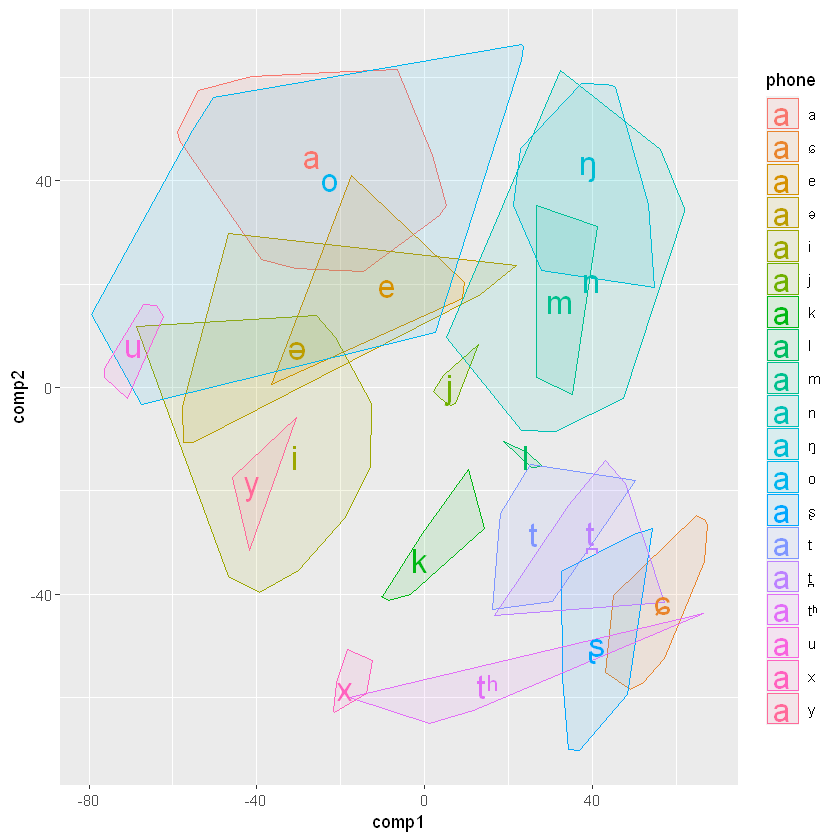

In [7]:
ggplot(hull_data, aes(x=comp1, y=comp2, color=phone, fill=phone)) + 
    geom_polygon(alpha=0.1) +     
    geom_text(data=hull_median, aes(label=phone), size=7)    

## Vowel data

In [8]:
# selected_phones = "[aeioənŋ]"
vdata = data[data$phone %in% unlist(strsplit("aeiyouə", split='')), ]

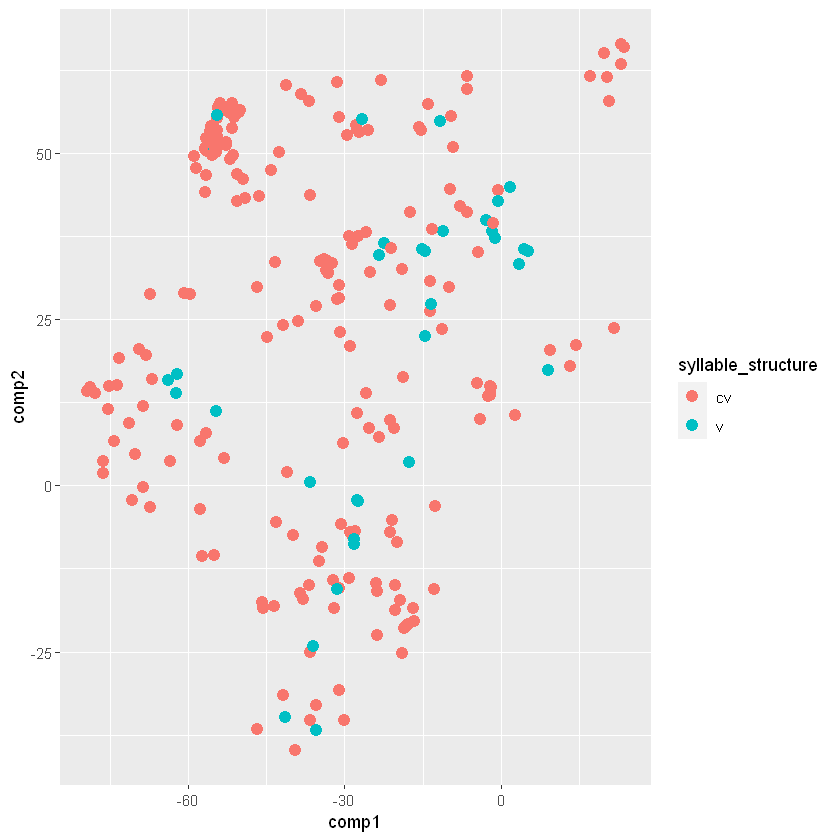

In [9]:
ggplot(vdata, aes(x=comp1, y=comp2, color=syllable_structure)) + 
    geom_point(size=3)

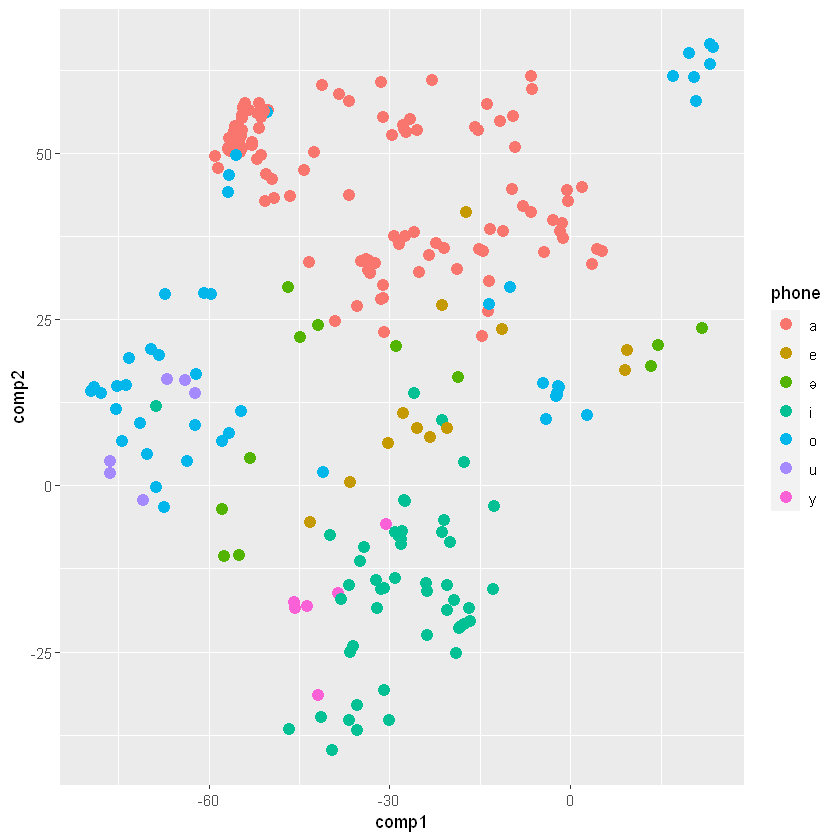

In [10]:
ggplot(vdata, aes(x=comp1, y=comp2, color=phone)) + 
    geom_point(size=3)

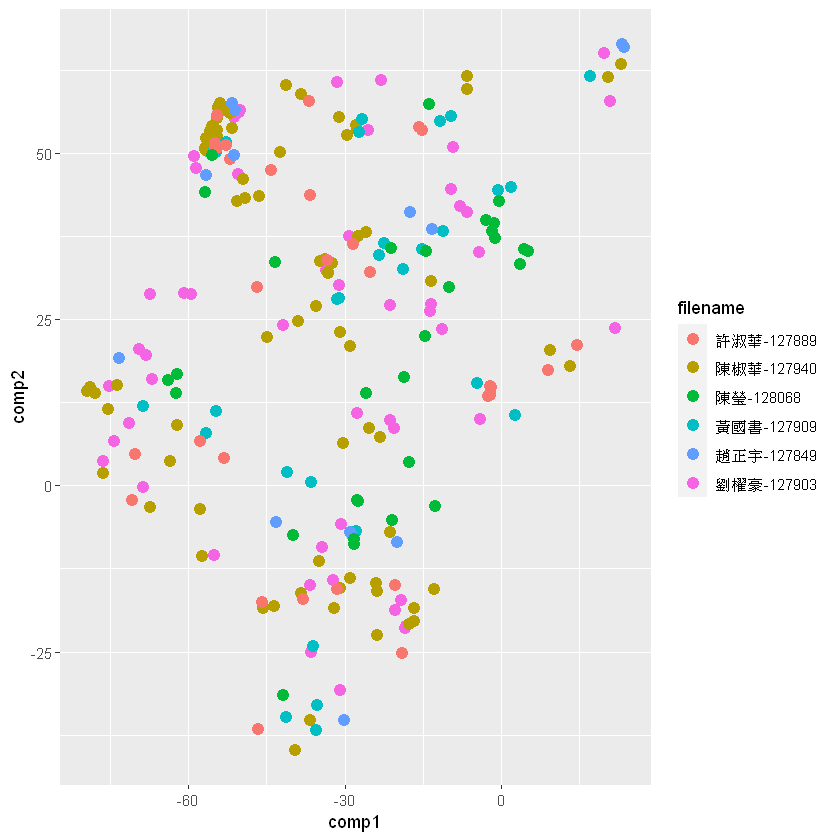

In [11]:
ggplot(vdata, aes(x=comp1, y=comp2, color=filename)) + 
    geom_point(size=3)

In [12]:
nrow(vdata)

[1] 262

In [13]:
length(unique(vdata$ac_id))

[1] 140

## Mixed model

In [14]:
m_f1 = lmer(freq_f1~comp1+comp2+(1|filename), data=vdata)
summary(m_f1)

Linear mixed model fit by REML ['lmerMod']
Formula: freq_f1 ~ comp1 + comp2 + (1 | filename)
   Data: vdata

REML criterion at convergence: 3364.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2668 -0.4620  0.0357  0.4674  3.3075 

Random effects:
 Groups   Name        Variance Std.Dev.
 filename (Intercept)  2289     47.85  
 Residual             22190    148.96  
Number of obs: 262, groups:  filename, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept) 726.94180   27.29482  26.633
comp1        -0.04142    0.41155  -0.101
comp2         0.34596    0.33235   1.041

Correlation of Fixed Effects:
      (Intr) comp1 
comp1  0.494       
comp2 -0.314 -0.015

In [15]:
ranef(m_f1)

$filename
              (Intercept)
許淑華-127889    51.37552
陳椒華-127940    38.26085
陳瑩-128068     -34.15729
黃國書-127909    14.24298
趙正宇-127849   -55.97470
劉櫂豪-127903   -13.74736

with conditional variances for "filename" 

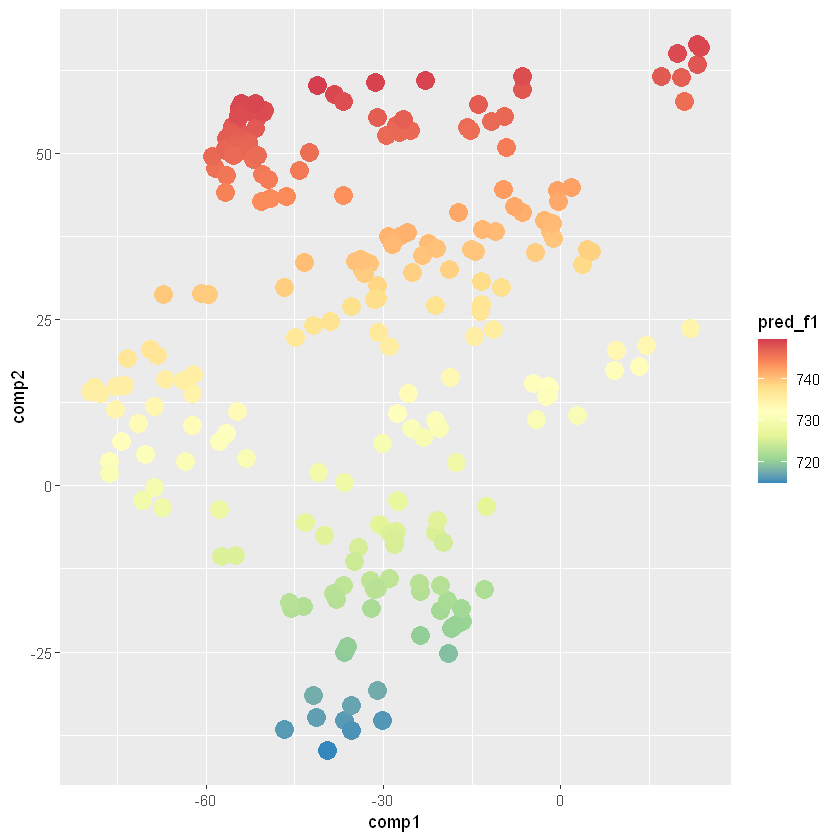

In [16]:
pred_f1 = predict(m_f1, re.form=NA)
ggplot(vdata, aes(x=comp1, y=comp2, color=pred_f1)) + 
    geom_point(size=5) + 
    scale_color_distiller(palette='Spectral')

In [17]:
m_f2 = lmer(freq_f2~comp1+comp2+(1|filename), data=vdata)
summary(m_f2)

Linear mixed model fit by REML ['lmerMod']
Formula: freq_f2 ~ comp1 + comp2 + (1 | filename)
   Data: vdata

REML criterion at convergence: 3654.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5470 -0.5013 -0.2547  0.1794  4.5663 

Random effects:
 Groups   Name        Variance Std.Dev.
 filename (Intercept)  1522     39.01  
 Residual             69314    263.28  
Number of obs: 262, groups:  filename, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept) 1209.5474    36.9889  32.700
comp1         -0.2283     0.7182  -0.318
comp2         -0.3574     0.5861  -0.610

Correlation of Fixed Effects:
      (Intr) comp1 
comp1  0.651       
comp2 -0.408 -0.006

In [18]:
ranef(m_f2)

$filename
              (Intercept)
許淑華-127889    9.280289
陳椒華-127940    2.091414
陳瑩-128068    -15.045691
黃國書-127909   24.314773
趙正宇-127849   22.751392
劉櫂豪-127903  -43.392178

with conditional variances for "filename" 

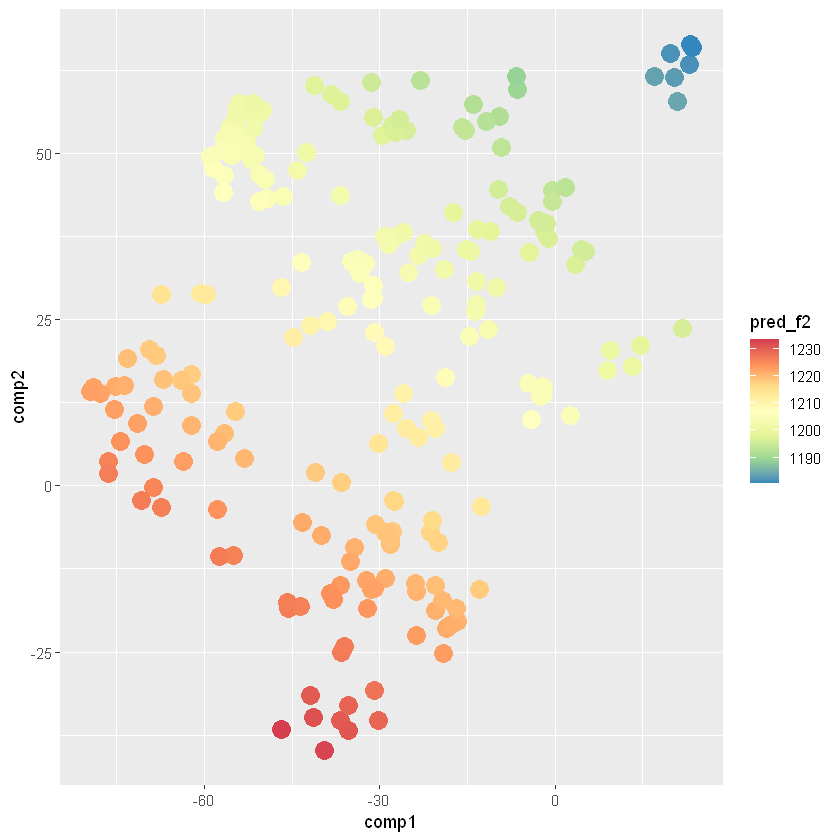

In [19]:
pred_f2 = predict(m_f2, re.form=NA)
ggplot(vdata, aes(x=comp1, y=comp2, color=pred_f2)) + 
    geom_point(size=5) + 
    scale_color_distiller(palette='Spectral')

## Get prediction error (bootstrap)

In [20]:
require(akima)

Loading required package: akima



In [21]:
predFun <- function(fit) {
    predict(fit, re.form=NA)
}


### F1 predictions

In [22]:
boot_mf1 <- bootMer(m_f1, nsim=200, FUN=predFun,seed=101)
predf1_mean = apply(boot_mf1$t, 2, mean)
predf1_se = apply(boot_mf1$t, 2, function(x) sd(x)/sqrt(length(x)))
interp_f1 = interp(vdata$comp1, vdata$comp2, predf1_se)
grid_f1se = expand.grid(interp_f1$x, interp_f1$y)
names(grid_f1se) = c("comp1", "comp2")
grid_f1se$f1_se = as.numeric(interp_f1$z)
grid_f1se = grid_f1se[!is.na(grid_f1se$f1_se),]

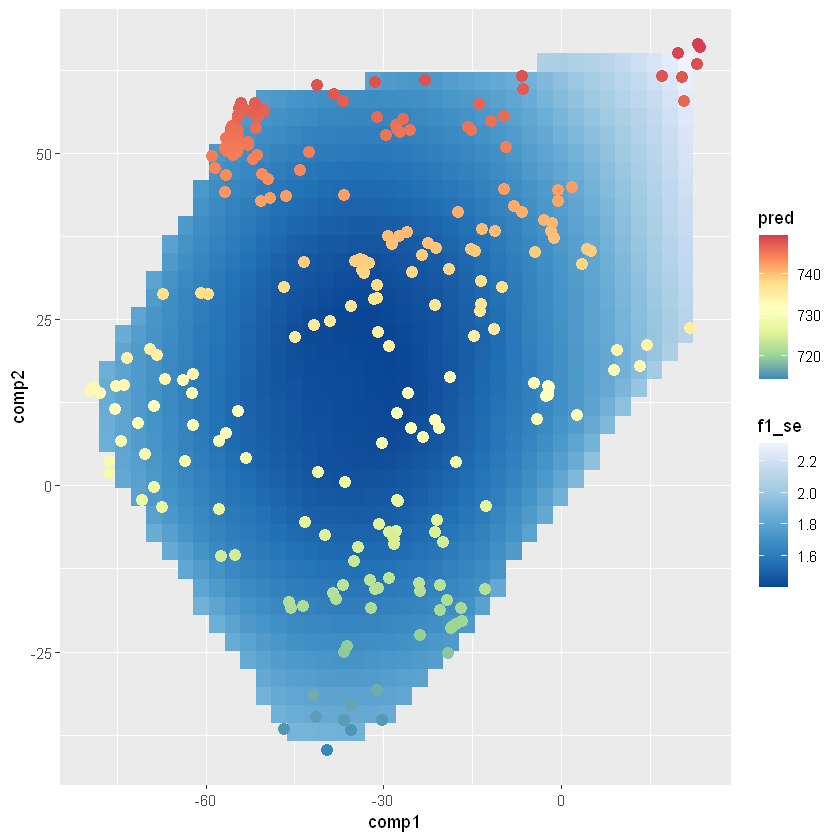

In [23]:
pred_f1 = data.frame(x=vdata$comp1, y=vdata$comp2, pred=predf1_mean)
ggplot() + 
    geom_raster(data=grid_f1se, aes(x=comp1, y=comp2, fill=f1_se)) + 
    geom_contour(color="white") + scale_fill_distiller(palette='Blues', direction=-1) + 
    geom_point(data=pred_f1, aes(x=x, y=y, color=pred), size=3) + 
    scale_color_distiller(palette='Spectral')

In [24]:
boot_mf2 <- bootMer(m_f2, nsim=200, FUN=predFun,seed=101)
predf2_mean = apply(boot_mf2$t, 2, mean)
predf2_se = apply(boot_mf2$t, 2, function(x) sd(x)/sqrt(length(x)))
interp_f2 = interp(vdata$comp1, vdata$comp2, predf2_se)
grid_f2se = expand.grid(interp_f2$x, interp_f2$y)
names(grid_f2se) = c("comp1", "comp2")
grid_f2se$f2_se = as.numeric(interp_f2$z)
grid_f2se = grid_f2se[!is.na(grid_f2se$f2_se),]

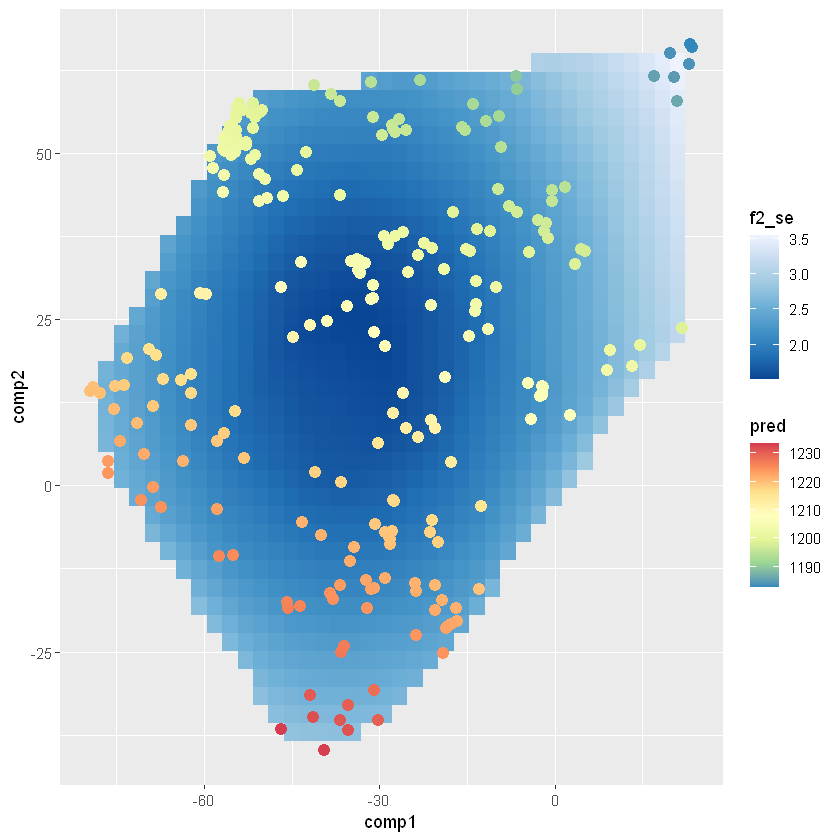

In [25]:
pred_f2 = data.frame(x=vdata$comp1, y=vdata$comp2, pred=predf2_mean)
ggplot() + 
    geom_raster(data=grid_f2se, aes(x=comp1, y=comp2, fill=f2_se)) + 
    geom_contour(color="white") + scale_fill_distiller(palette='Blues', direction=-1) + 
    geom_point(data=pred_f2, aes(x=x, y=y, color=pred), size=3) + 
    scale_color_distiller(palette='Spectral')